In [1]:
!pip install ultralytics opencv-python numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.1 MB/s eta 0:00:00


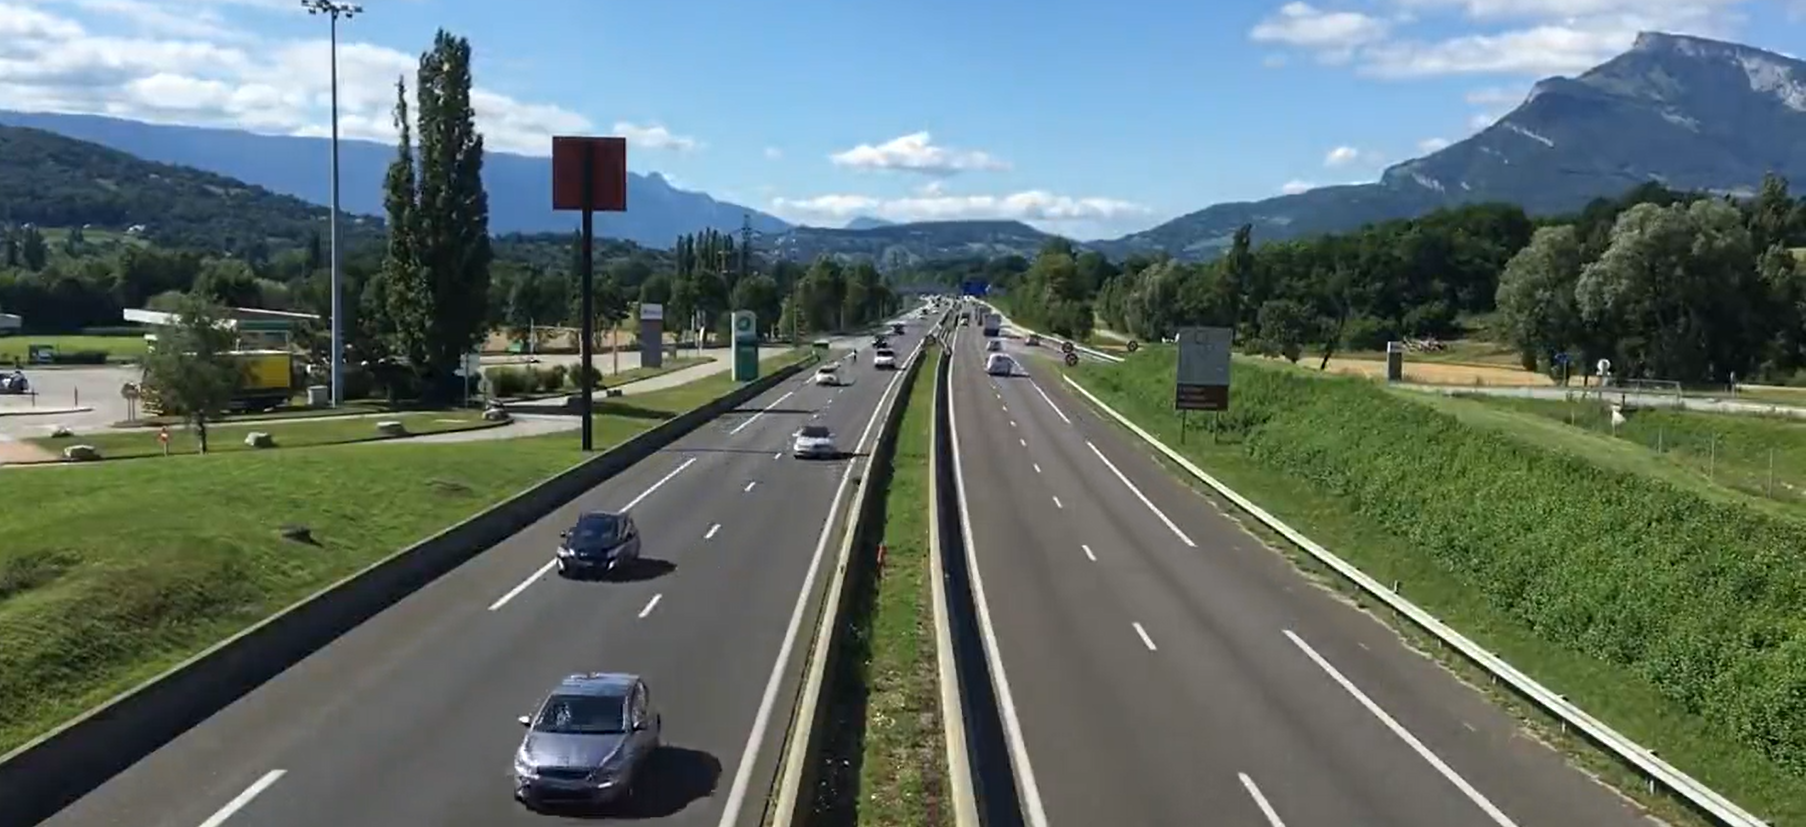

In [6]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/test.jpg")
cv2_imshow(img)



image 1/1 /content/test.jpg: 320x640 4 cars, 109.1ms
Speed: 2.4ms preprocess, 109.1ms inference, 4.2ms postprocess per image at shape (1, 3, 320, 640)


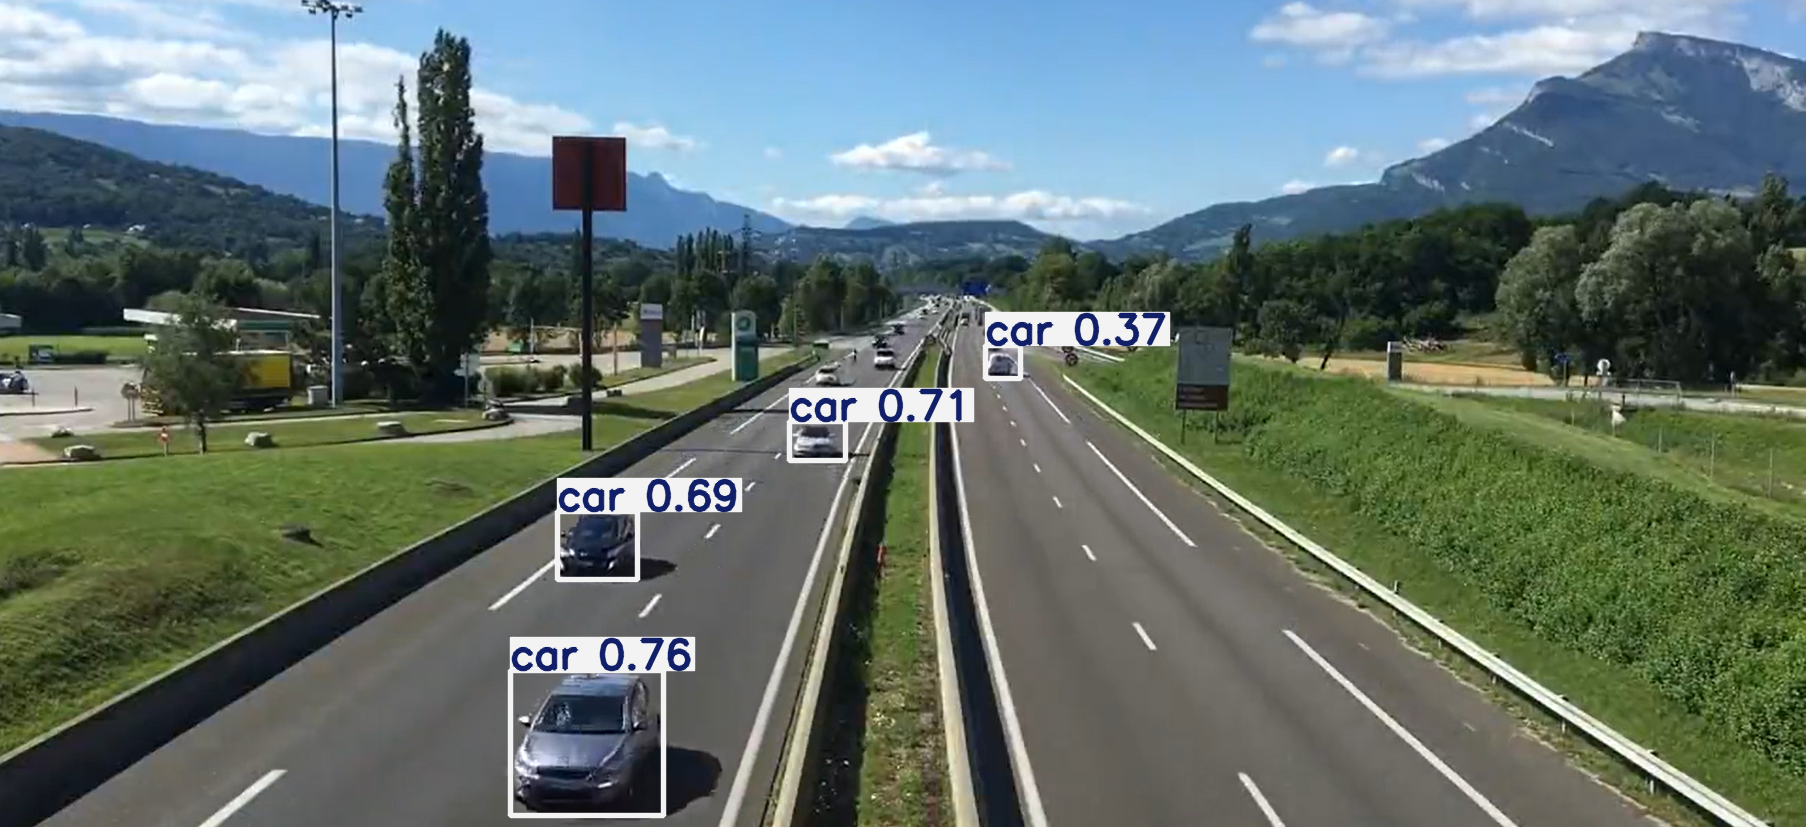

In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model("/content/test.jpg")
results[0].show()



0: 384x640 4 cars, 144.1ms
Speed: 4.3ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


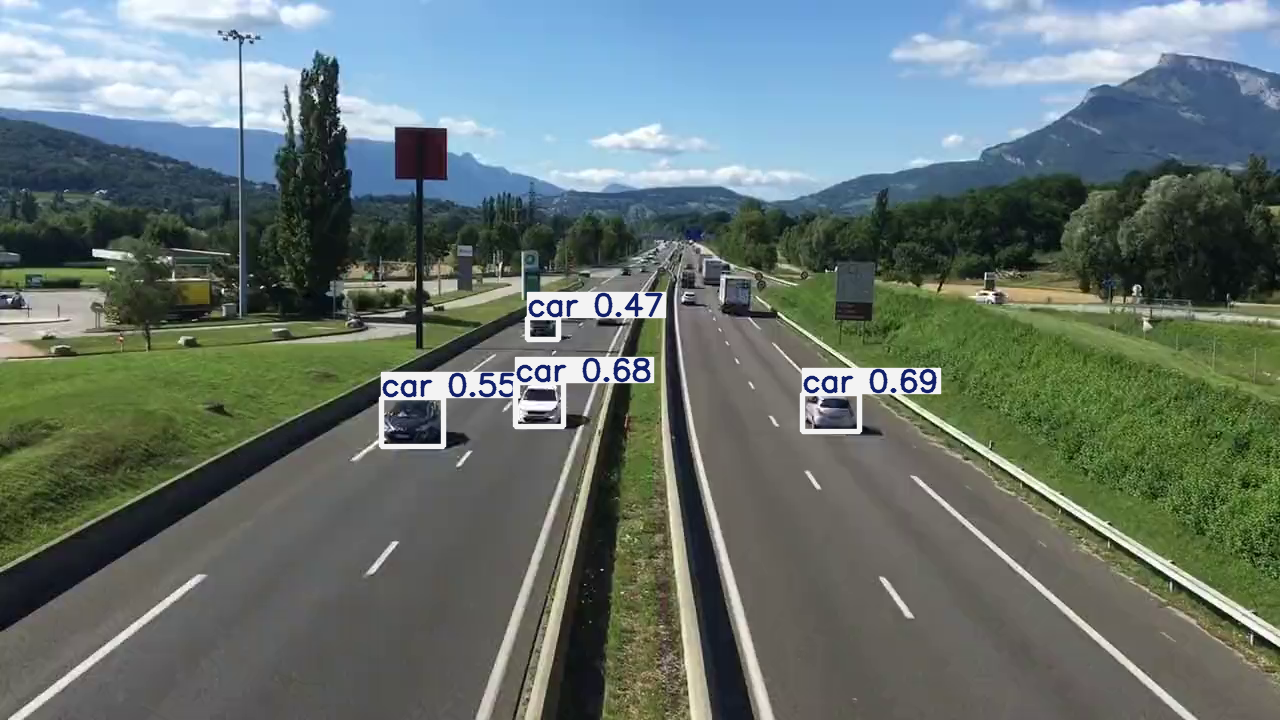

In [8]:
import cv2
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
cap = cv2.VideoCapture("/content/test.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    annotated = results[0].plot()
    cv2_imshow(annotated)
    break   # only first frame (for speed)

cap.release()


In [9]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

cap = cv2.VideoCapture("/content/test.mp4")

fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(
    "output.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (w, h)
)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)
    annotated = results[0].plot()
    out.write(annotated)

cap.release()
out.release()

print("Saved as output.mp4")


Streaming output truncated to the last 5000 lines.
Speed: 4.6ms preprocess, 145.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 137.6ms
Speed: 4.1ms preprocess, 137.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 137.4ms
Speed: 4.0ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 139.1ms
Speed: 5.9ms preprocess, 139.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 cars, 139.0ms
Speed: 5.6ms preprocess, 139.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 149.9ms
Speed: 4.4ms preprocess, 149.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 cars, 1 truck, 153.9ms
Speed: 2.7ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 141.5ms
Speed: 4.1ms preprocess, 141.5ms inference, 1.0ms postproc

In [10]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

cap = cv2.VideoCapture("test.mp4")

fps = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter("track_output.mp4",
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      fps, (w, h))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        for box, track_id in zip(results[0].boxes.xyxy, results[0].boxes.id):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f"ID {int(track_id)}",
                        (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                        (0,255,0), 2)

    out.write(frame)

cap.release()
out.release()

print("Saved as track_output.mp4")



Streaming output truncated to the last 5000 lines.
Speed: 2.7ms preprocess, 148.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 143.0ms
Speed: 4.2ms preprocess, 143.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 140.7ms
Speed: 3.1ms preprocess, 140.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 145.8ms
Speed: 2.9ms preprocess, 145.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 152.5ms
Speed: 3.8ms preprocess, 152.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 149.3ms
Speed: 2.6ms preprocess, 149.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 138.6ms
Speed: 2.6ms preprocess, 138.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 143.1ms
Speed: 3.0ms preprocess, 143.1ms inference, 1.1ms postprocess per i

In [11]:
import cv2
from ultralytics import YOLO
from collections import defaultdict, deque
import math

model = YOLO("yolov8n.pt")

cap = cv2.VideoCapture("test.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter("speed_output.mp4",
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      fps, (w, h))

track_history = defaultdict(lambda: deque(maxlen=5))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, persist=True)

    if results[0].boxes.id is not None:
        for box, track_id in zip(results[0].boxes.xyxy, results[0].boxes.id):
            x1, y1, x2, y2 = map(int, box)
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            track_history[int(track_id)].append((cx, cy))

            speed = 0
            if len(track_history[int(track_id)]) >= 2:
                (x_prev, y_prev) = track_history[int(track_id)][-2]
                dist = math.hypot(cx - x_prev, cy - y_prev)
                speed = dist * fps  # pixel/sec (approx)

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f"ID {int(track_id)} | Speed {int(speed)}",
                        (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                        (0,255,0), 2)

    out.write(frame)

cap.release()
out.release()

print("Saved as speed_output.mp4")


Streaming output truncated to the last 5000 lines.
Speed: 5.0ms preprocess, 142.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 141.1ms
Speed: 6.1ms preprocess, 141.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 145.8ms
Speed: 4.5ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 141.1ms
Speed: 8.5ms preprocess, 141.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 150.7ms
Speed: 6.2ms preprocess, 150.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 139.5ms
Speed: 4.3ms preprocess, 139.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 209.4ms
Speed: 3.4ms preprocess, 209.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 205.4ms
Speed: 3.0ms preprocess, 205.4ms inference, 1.4ms postprocess per i

In [13]:
!git config --global user.email "soni.gurudeep0408@gmail.com"
!git config --global user.name "GurudeepSoni"


In [14]:
!git clone https://github.com/GurudeepSoni/vehicle-detection-streamlit.git
%cd vehicle-detection-streamlit


Cloning into 'vehicle-detection-streamlit'...
/content/vehicle-detection-streamlit


In [15]:
%%bash
cat << 'EOF' > app.py
import streamlit as st
import cv2, tempfile
from ultralytics import YOLO

st.title("Vehicle Detection App")
video = st.file_uploader("Upload vehicle video", type=["mp4","avi"])
if video:
    tfile = tempfile.NamedTemporaryFile(delete=False)
    tfile.write(video.read())
    model = YOLO("yolov8n.pt")
    cap = cv2.VideoCapture(tfile.name)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter("result.mp4",
                          cv2.VideoWriter_fourcc(*"mp4v"),
                          fps, (w,h))
    st.text("Processing...")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        results = model(frame)
        out.write(results[0].plot())
    cap.release()
    out.release()
    st.video("result.mp4")
EOF


In [16]:
%%bash
cat << 'EOF' > requirements.txt
streamlit
ultralytics
opencv-python-headless
numpy
torch
torchvision
EOF


In [17]:
!git add .
!git commit -m "Initial Streamlit app"


[main (root-commit) 055e035] Initial Streamlit app
 2 files changed, 33 insertions(+)
 create mode 100644 app.py
 create mode 100644 requirements.txt


In [18]:
!git push origin main


fatal: could not read Username for 'https://github.com': No such device or address
